In this project, we aim to predict the Happiness Index from the Big Mac Index using a linear regression model, however the intention of the project is to show that we are able to use Python tools to overcome this challenge, so the work may not be statistically correct for the most part. We also evaluate the performance of the model to check its suitability for the matter in the hand. We assume that the requirements for the linear regression model without checking. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set(rc={"figure.figsize":(11.7, 8.27)})
import country_converter as coco
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score

cc = coco.CountryConverter()

We load datasets for Happiness and Bigmac index. In the Happiness index dataset, we are interested in *Index* value, which is a straightforward value that is bigger is better. In the Bigmac index dataset, we are interested in *USD* value, which shows whether and how much a country's local currency is over- or under-valued adjusted by GDP based on United States Dollar, e.g. 0.3 means 30% over-valued and -0.13 means 13% under-valued.

In [2]:
happiness = pd.read_csv("happiness.csv")
bigmac = pd.read_csv("https://github.com/TheEconomist/big-mac-data/raw/master/output-data/big-mac-adjusted-index.csv")

In [3]:
happiness

,Country,Year,Index,Rank
0,Afghanistan,2013,4.040,143
1,Afghanistan,2015,3.575,153
2,Afghanistan,2016,3.360,154
3,Afghanistan,2017,3.794,141
4,Afghanistan,2018,3.632,145
...,...,...,...,...
1518,Zimbabwe,2019,3.663,146
1519,Zimbabwe,2020,3.299,151
1520,Zimbabwe,2021,3.145,148
1521,Zimbabwe,2022,2.995,144


In [4]:
bigmac

,date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,GDP_bigmac,adj_price,USD,EUR,GBP,JPY,CNY
0,2000-04-01,ARG,ARS,Argentina,2.50,1.000000,2.500000,8317.729280,1.941787,0.36269,NaN,-0.07842,0.09662,0.96313
1,2000-04-01,AUS,AUD,Australia,2.59,1.680000,1.541667,28016.579459,2.286551,-0.28638,NaN,-0.51738,-0.42572,0.02807
2,2000-04-01,BRA,BRL,Brazil,2.95,1.790000,1.648045,4578.628339,1.876347,-0.07036,NaN,-0.37129,-0.25188,0.33927
3,2000-04-01,GBR,GBP,Britain,1.90,0.632911,3.002000,20147.974737,2.148837,0.47865,NaN,0.00000,0.18994,1.13019
4,2000-04-01,CAN,CAD,Canada,2.85,1.470000,1.938776,24539.930947,2.225703,-0.07803,NaN,-0.37648,-0.25805,0.32823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,2024-01-01,UKR,UAH,Ukraine,110.00,37.444300,2.937697,7707.174315,4.155811,-0.34840,-0.43476,-0.40921,0.14432,-0.11592
1536,2024-01-01,ARE,AED,United Arab Emirates,18.00,3.672950,4.900693,59671.140639,4.980401,-0.09297,-0.21318,-0.17761,0.59291,0.23064
1537,2024-01-01,USA,USD,United States,5.69,1.000000,5.690000,76343.250000,5.244963,0.00000,-0.13254,-0.09332,0.75617,0.35678
1538,2024-01-01,URY,UYU,Uruguay,275.00,39.065000,7.039549,17054.791147,4.304144,0.50761,0.30779,0.36691,1.64762,1.04549


We clean and prepare two datasets to merge them together.

In [5]:
happiness["iso_a3"] = cc.convert(names=happiness["Country"], to="ISO3")
happiness = happiness[["iso_a3","Country", "Year", "Index"]]
happiness = happiness.rename(columns={"Country": "country", "Year":"year", "Index":"happiness"})
happiness

,iso_a3,country,year,happiness
0,AFG,Afghanistan,2013,4.040
1,AFG,Afghanistan,2015,3.575
2,AFG,Afghanistan,2016,3.360
3,AFG,Afghanistan,2017,3.794
4,AFG,Afghanistan,2018,3.632
...,...,...,...,...
1518,ZWE,Zimbabwe,2019,3.663
1519,ZWE,Zimbabwe,2020,3.299
1520,ZWE,Zimbabwe,2021,3.145
1521,ZWE,Zimbabwe,2022,2.995


In [6]:
bigmac["date"] = pd.to_datetime(bigmac["date"], format="%Y-%m-%d")
bigmac["year"] = bigmac["date"].dt.year
bigmac = bigmac[["iso_a3", "year", "USD"]]
bigmac = bigmac.rename(columns={"USD": "bigmac"})
bigmac

,iso_a3,year,bigmac
0,ARG,2000,0.36269
1,AUS,2000,-0.28638
2,BRA,2000,-0.07036
3,GBR,2000,0.47865
4,CAN,2000,-0.07803
...,...,...,...
1535,UKR,2024,-0.34840
1536,ARE,2024,-0.09297
1537,USA,2024,0.00000
1538,URY,2024,0.50761


In [7]:
df = pd.merge(bigmac, happiness, how="left", left_on=["iso_a3", "year"], right_on=["iso_a3", "year"])
df = df.dropna()
df = df.drop(columns=("iso_a3"))
df

,year,bigmac,country,happiness
576,2013,0.28937,Argentina,6.562
577,2013,0.16907,Australia,7.350
578,2013,0.96118,Brazil,6.849
579,2013,0.13657,United Kingdom,6.883
580,2013,0.45250,Canada,7.477
...,...,...,...,...
1482,2023,-0.36975,Ukraine,5.071
1483,2023,-0.06285,United Arab Emirates,6.571
1484,2023,0.00000,United States,6.894
1485,2023,0.46953,Uruguay,6.494


We check the correlation between two indexes to see whether linear model is a good choice or not. We see that there is a rough positive linear relationship between two indexes.

In [8]:
df.corr(numeric_only=True)["happiness"]

year        -0.083524
bigmac       0.511595
happiness    1.000000
Name: happiness, dtype: float64

/home/ppx/miniconda3/envs/simp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


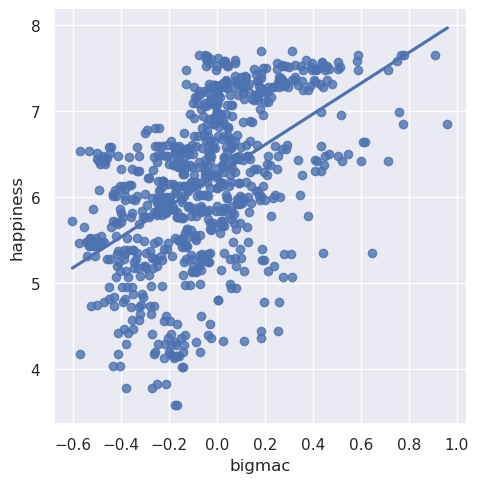

In [9]:
sns.lmplot(y="happiness", x="bigmac", data=df, ci=False)

We divide the dataset into training and test set.

In [10]:
train = df[df["year"] <= 2021].copy()
test = df[df["year"] > 2021].copy()

We fit model to the set and make predictions. Also we calculate the mean absolute error and $R^2$ score.

In [11]:
predictor = ["bigmac"]
target = ["happiness"]

In [12]:
regr = linear_model.LinearRegression()
regr.fit(train[predictor], train[target])

LinearRegression()

In [13]:
prediction = regr.predict(test[predictor])
test["prediction"] = prediction.round(3)
test

,year,bigmac,country,happiness,prediction
1276,2022,0.20193,Argentina,5.967,6.604
1277,2022,-0.09120,Australia,7.162,6.090
1278,2022,-0.26401,Azerbaijan,5.173,5.787
1279,2022,-0.04369,Bahrain,6.647,6.173
1280,2022,0.19614,Brazil,6.293,6.594
...,...,...,...,...,...
1482,2023,-0.36975,Ukraine,5.071,5.601
1483,2023,-0.06285,United Arab Emirates,6.571,6.140
1484,2023,0.00000,United States,6.894,6.250
1485,2023,0.46953,Uruguay,6.494,7.074


In [14]:
error = mean_absolute_error(test["happiness"], test["prediction"])
error

0.5822871794871795

In [15]:
test.describe()["happiness"]

count    195.000000
mean       6.045400
std        0.894385
min        3.777000
25%        5.559000
50%        6.123000
75%        6.584500
max        7.636000
Name: happiness, dtype: float64

In [16]:
r2_score(test["happiness"], test["prediction"])

0.24204309986381645

The mean absolute error is lower than the standard deviation, that's a good indicator that the model may be good fit, however $R^2$ score is very low, so it is better to take the model with grain of salt.